# Flow training and visualization
In this notebook, we train normalizing flows to fit predefined prior distributions, testing their expressivity. The plots are generated to visualize the learned distributions for given layers $K$, and the training loss is plotted to compare the expressivity of different flows.

In [8]:
%load_ext autoreload
%autoreload 2

# Import required packages
import torch
import numpy as np
import normflow as nf

from matplotlib import pyplot as plt
from tqdm import tqdm

print("PyTorch version: %s" % torch.__version__)
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Using device: %s" % dev)

#z shape is (batch_size, num_samples, dim)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
PyTorch version: 1.4.0
Using device: cuda


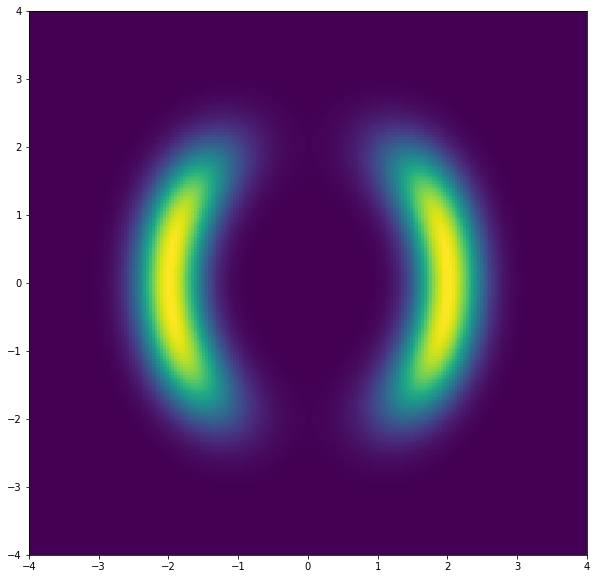

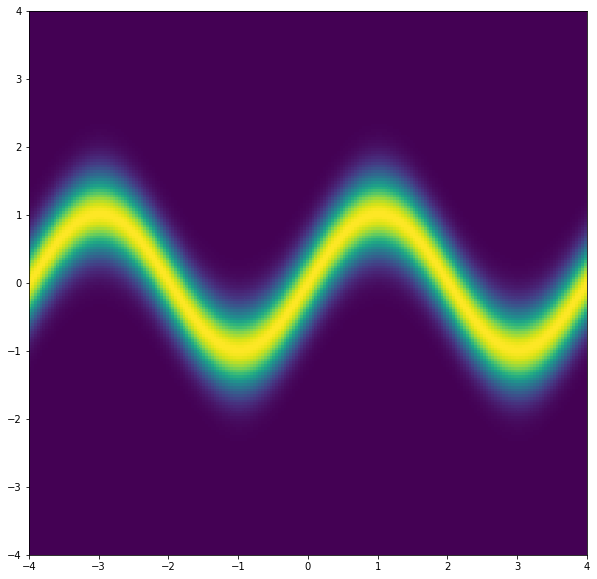

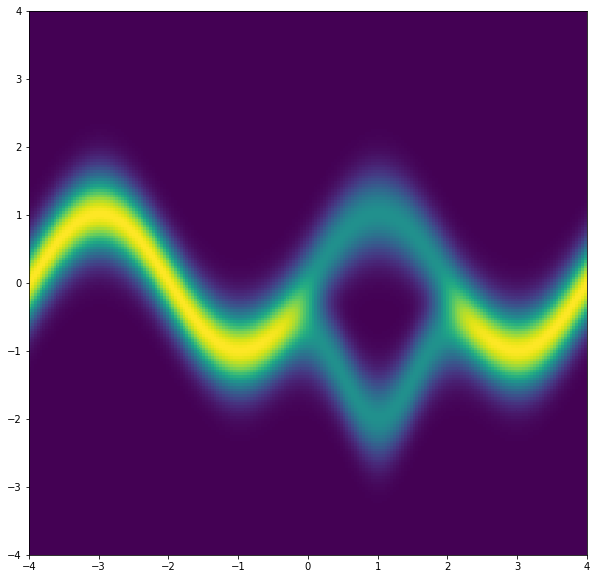

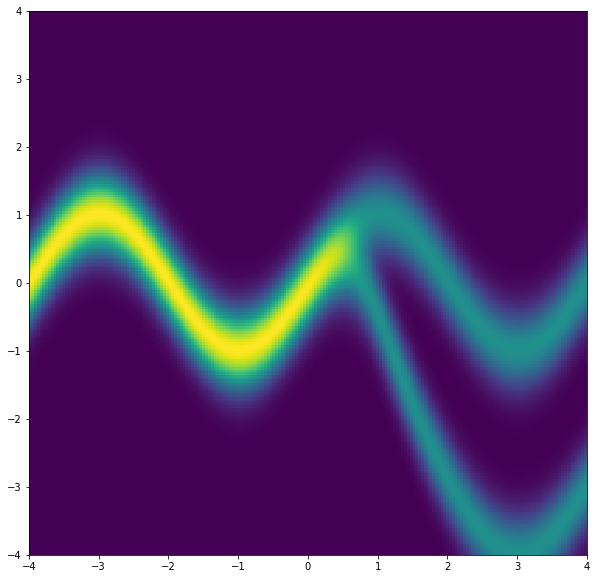

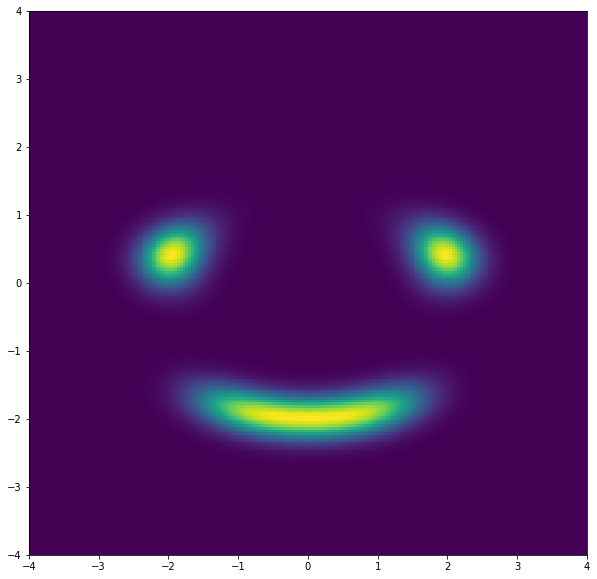

In [2]:
priors = []
priors.append(nf.distributions.TwoModes(2.0, 0.2))
priors.append(nf.distributions.Sinusoidal(0.4, 4))
priors.append(nf.distributions.Sinusoidal_gap(0.4, 4))
priors.append(nf.distributions.Sinusoidal_split(0.4, 4))
priors.append(nf.distributions.Smiley(0.15))


# Plot prior distributions
grid_size = 200
grid_length = 4.0
grid_shape = ([-grid_length, grid_length], [-grid_length, grid_length])

space_mesh = torch.linspace(-grid_length, grid_length, grid_size)
xx, yy = torch.meshgrid(space_mesh, space_mesh)
z = torch.cat([xx.unsqueeze(2), yy.unsqueeze(2)], 2)

K_arr = [2, 8, 32]
max_iter = 30000
batch_size = 512
num_samples = 256
save_iter = 1000

for k in range(5):
    log_prob = priors[k].log_prob(z)
    prob = torch.exp(log_prob)

    plt.figure(figsize=(10, 10))
    plt.pcolormesh(xx, yy, prob)
    plt.show()

K = 2


100%|██████████| 30000/30000 [02:23<00:00, 209.30it/s]


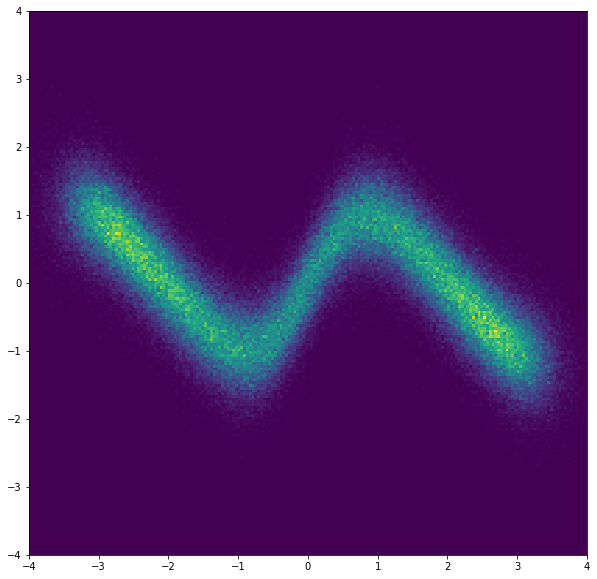

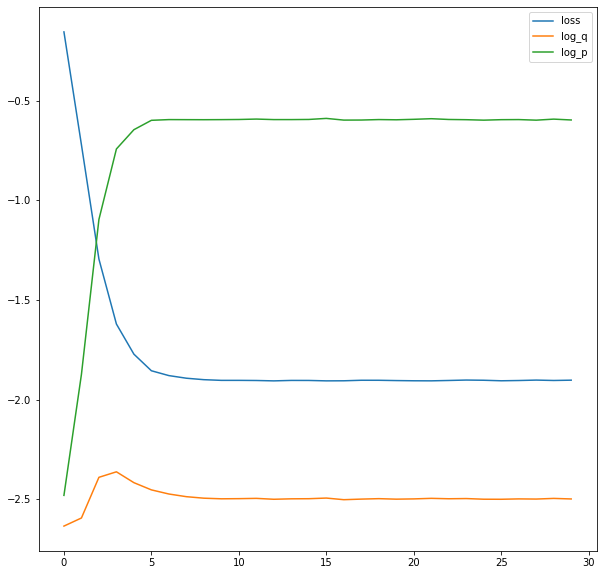

100%|██████████| 30000/30000 [02:31<00:00, 197.93it/s]


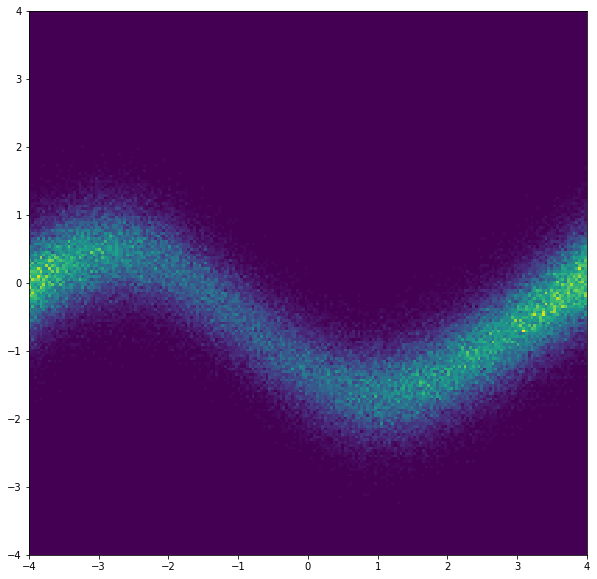

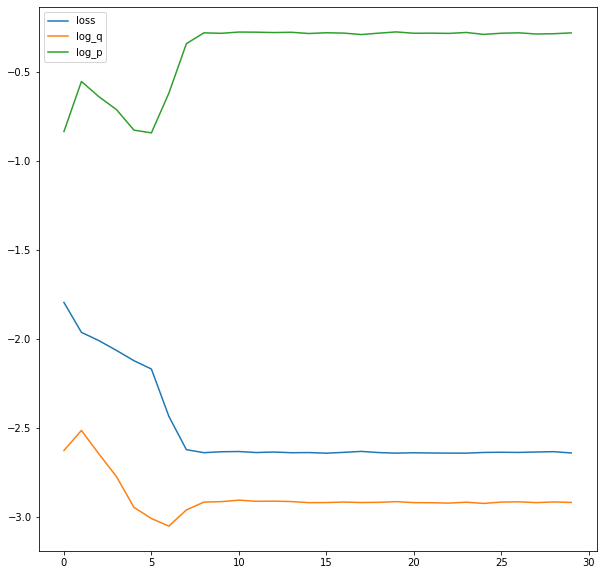

100%|██████████| 30000/30000 [02:28<00:00, 202.58it/s]


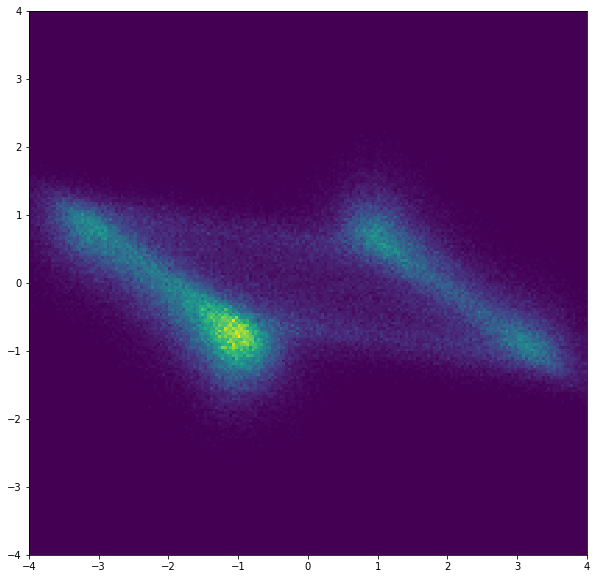

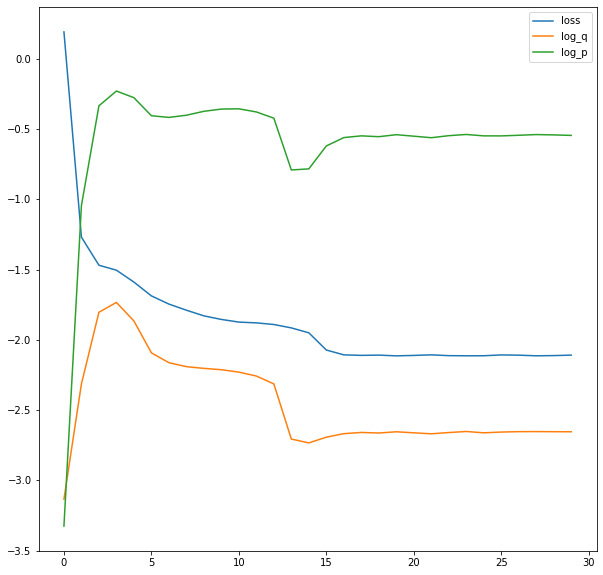

  0%|          | 8/30000 [00:00<06:17, 79.55it/s]

K = 8


100%|██████████| 30000/30000 [06:11<00:00, 80.70it/s]


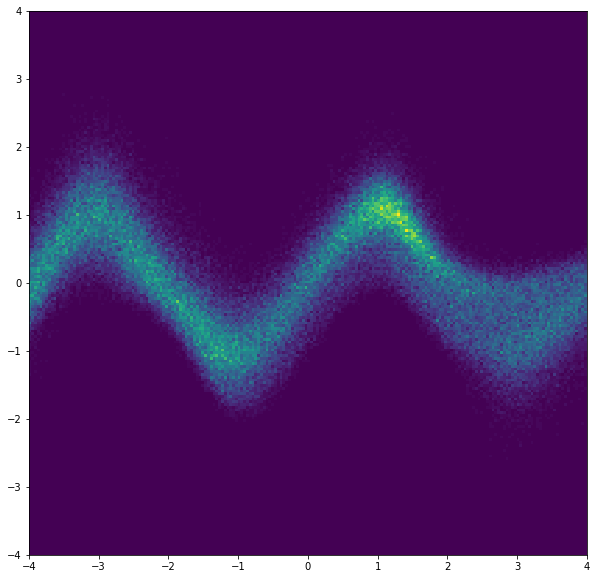

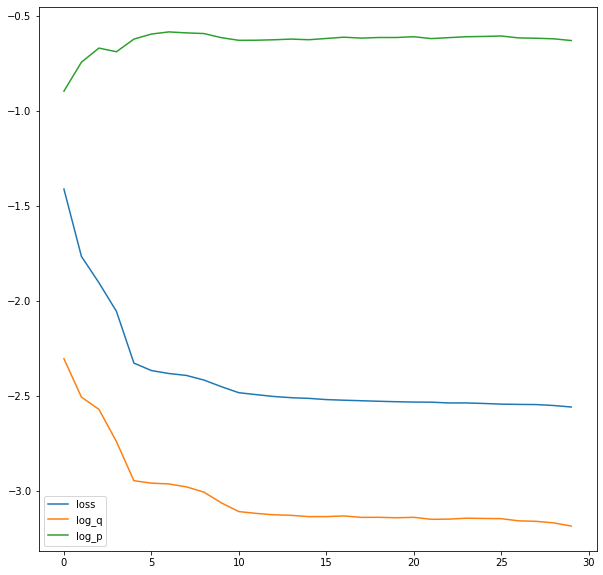

100%|██████████| 30000/30000 [06:30<00:00, 76.91it/s]


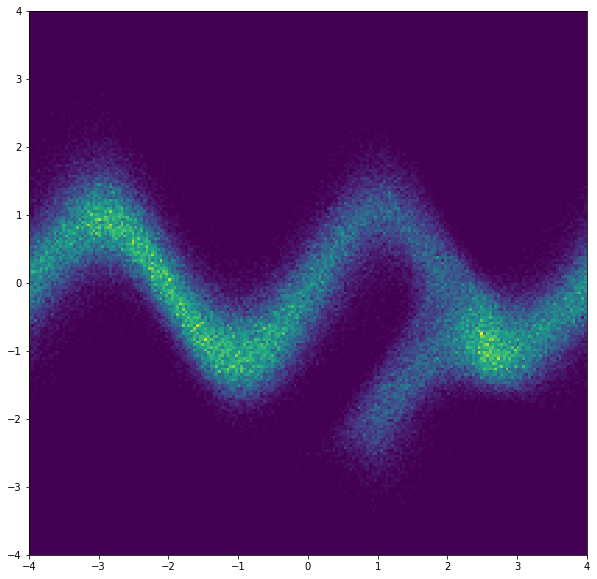

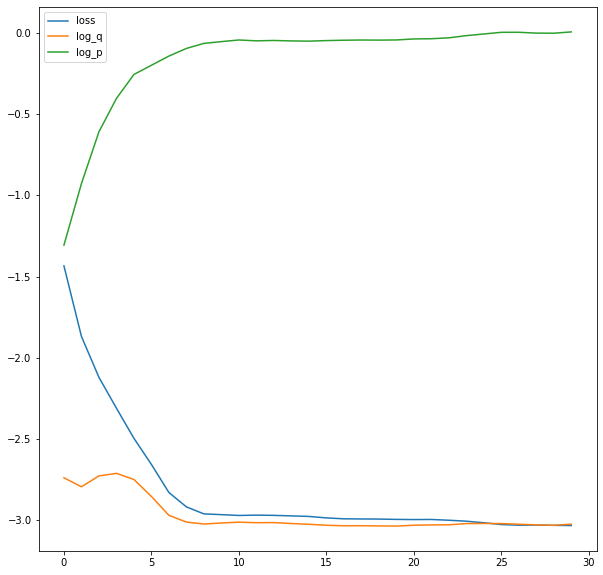

100%|██████████| 30000/30000 [06:28<00:00, 77.23it/s]


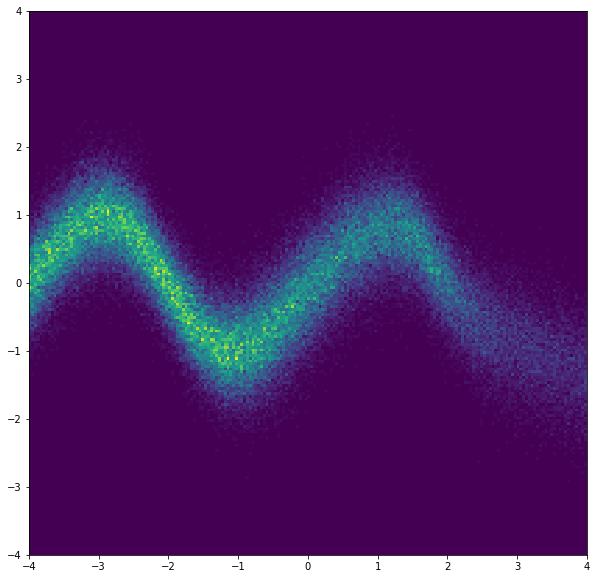

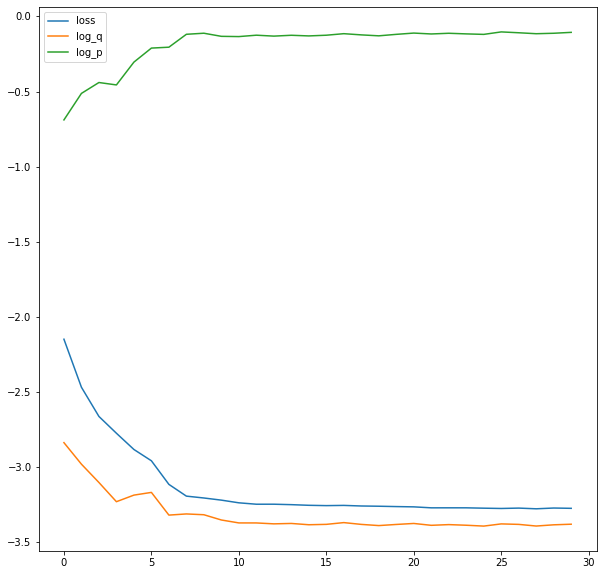

  0%|          | 2/30000 [00:00<25:17, 19.77it/s]

K = 32


100%|██████████| 30000/30000 [22:49<00:00, 21.91it/s]


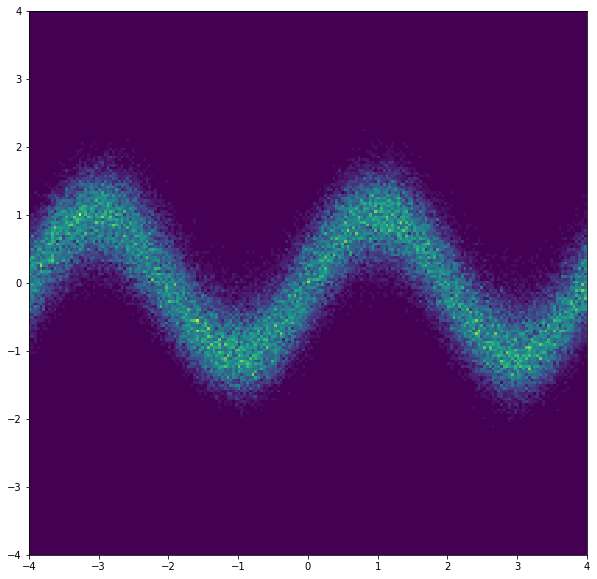

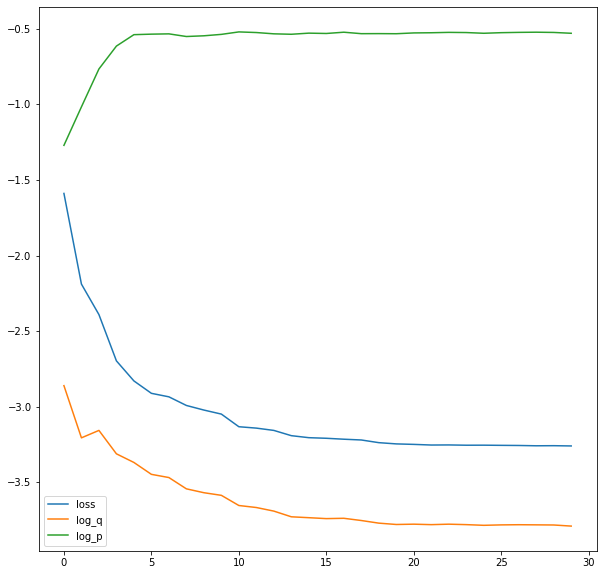

 95%|█████████▌| 28581/30000 [22:07<01:05, 21.68it/s]

In [ ]:
# Planar flows
K_arr = [2, 8, 32]
for K in K_arr:
    
    print("K = {}".format(K))
    for k in range(1,4):
        if k == 0 or k == 4:
            anneal_iter = 10000
        else: # turn annealing off when fitting to sinusoidal distributions
            anneal_iter = 1
        
        flows = []
        for i in range(K):
            flows += [nf.flows.Planar((2,))]

        q0 = nf.distributions.ConstDiagGaussian(np.zeros(2), 2.0)
        nfm = nf.NormalizingFlow(prior=priors[k], q0=q0, flows=flows)
        nfm.to(dev) # Move model on GPU if available
    
        # Train model
        loss_hist = np.array([])
        log_q_hist = np.array([])
        log_p_hist = np.array([])
        x = torch.zeros(batch_size, device=dev)

        optimizer = torch.optim.Adam(nfm.parameters(), lr=1e-3, weight_decay=1e-3)
        for it in tqdm(range(max_iter)):
            optimizer.zero_grad()
            _, log_q, log_p = nfm(x, num_samples)
            mean_log_q = torch.mean(log_q)
            mean_log_p = torch.mean(log_p)
            loss = mean_log_q - np.min([1.0, 0.01 + it / anneal_iter]) * mean_log_p
            loss.backward()
            optimizer.step()
            
            if (it + 1) % save_iter == 0:
                loss_hist = np.append(loss_hist, loss.cpu().data.numpy())
                log_q_hist = np.append(log_q_hist, mean_log_q.cpu().data.numpy())
                log_p_hist = np.append(log_p_hist, mean_log_p.cpu().data.numpy())

        # Plot learned posterior distribution
        z, _, _ = nfm(torch.zeros(512).to(dev), num_samples=512)
        z_np = z.cpu().data.numpy()
        plt.figure(figsize=(10, 10))
        plt.hist2d(z_np[:, :, 0].flatten(), z_np[:, :, 1].flatten(), (grid_size, grid_size), grid_shape)
        plt.show()
        np.save("K={}-k={}".format(K,k), (z_np, loss.cpu().data.numpy()))
    
        # Plot training history
        plt.figure(figsize=(10, 10))
        plt.plot(loss_hist, label='loss')
        plt.plot(log_q_hist, label='log_q')
        plt.plot(log_p_hist, label='log_p')
        plt.legend()
        plt.show()
        

K = 2


100%|██████████| 30000/30000 [02:20<00:00, 214.08it/s]


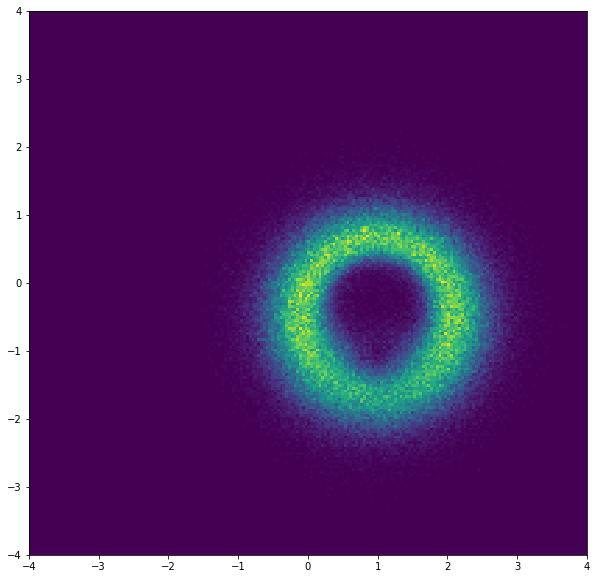

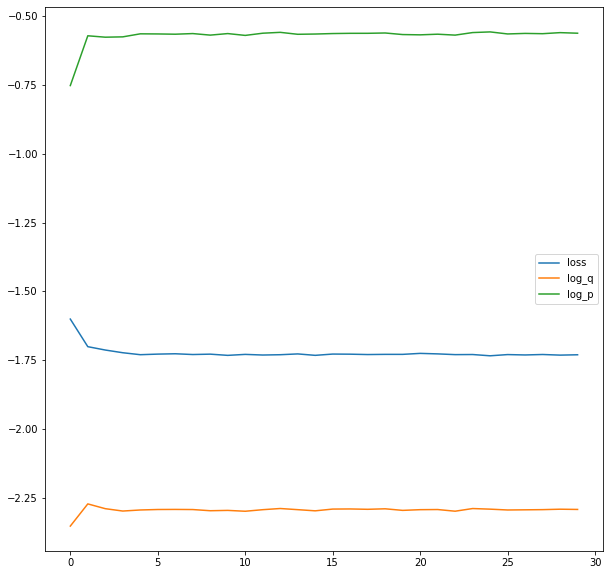

100%|██████████| 30000/30000 [02:17<00:00, 218.75it/s]


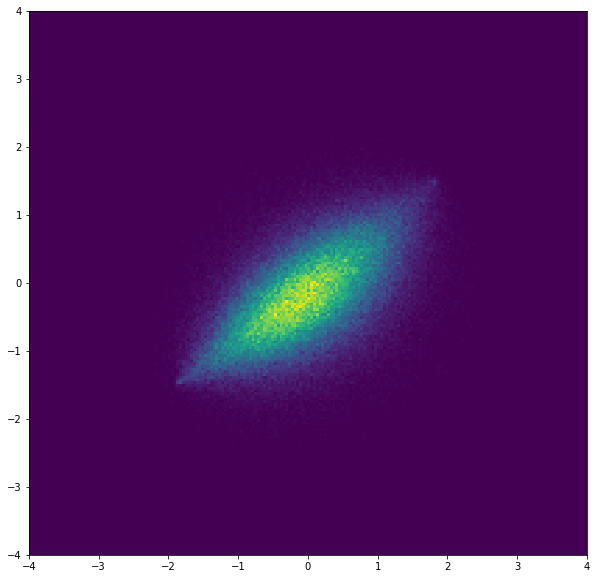

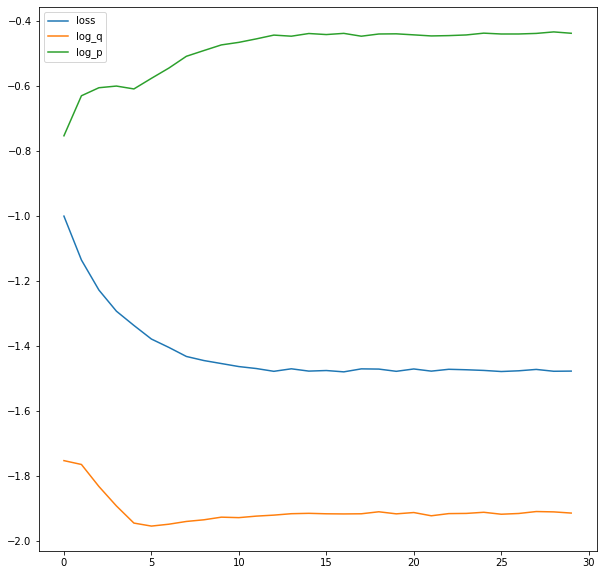

  0%|          | 8/30000 [00:00<06:18, 79.22it/s]

K = 8


100%|██████████| 30000/30000 [06:02<00:00, 82.72it/s]


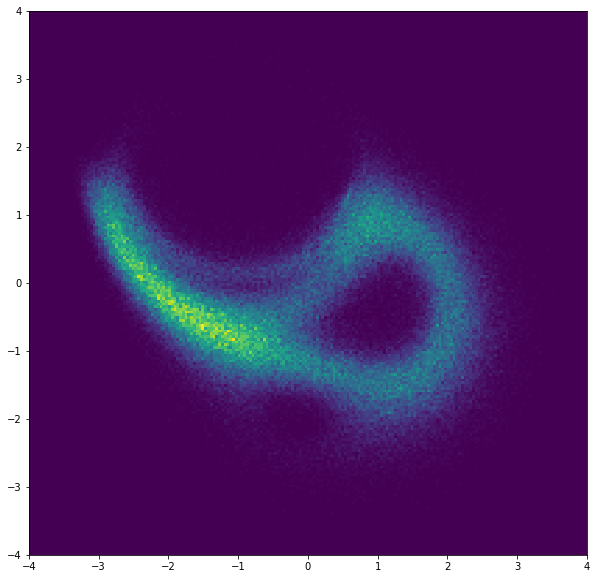

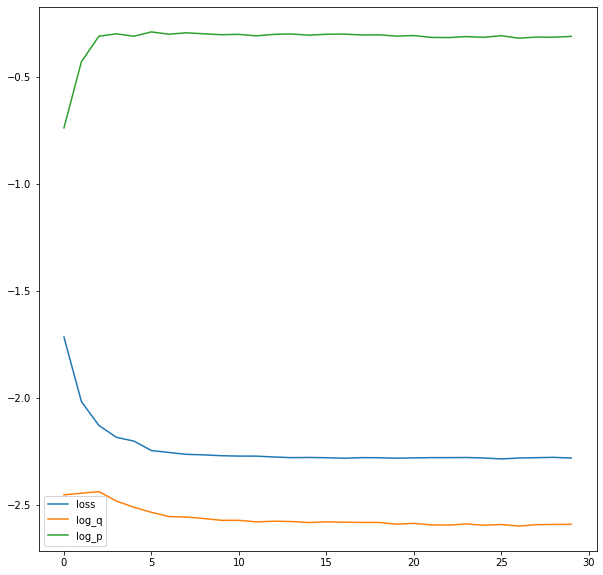

100%|██████████| 30000/30000 [06:00<00:00, 83.22it/s]


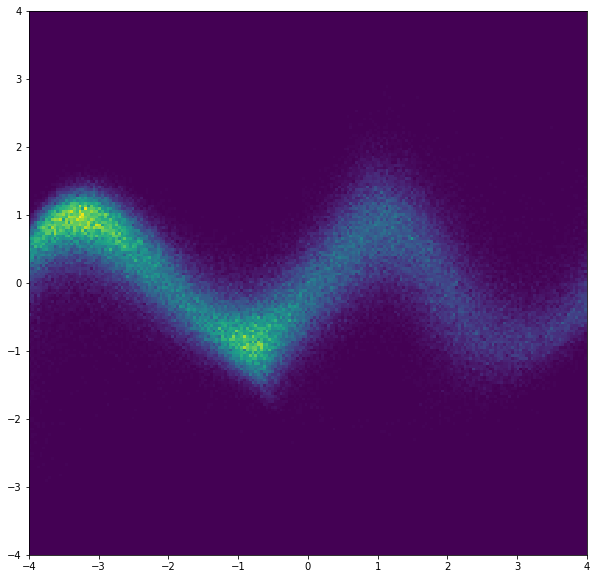

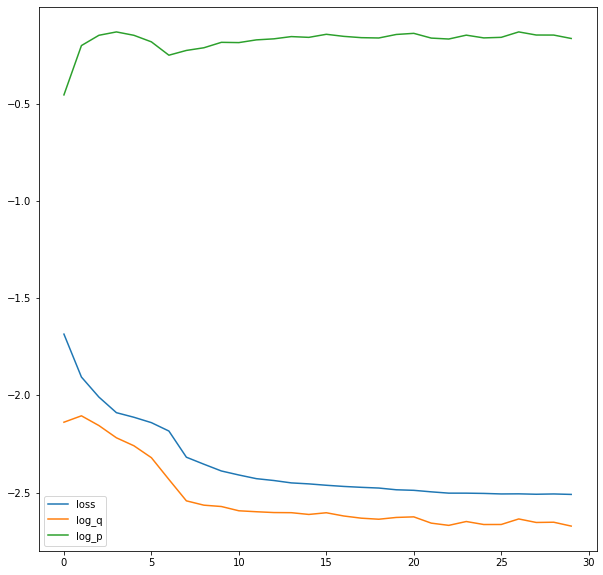

In [3]:
# Radial flows
K_arr = [2,8]
max_iter = 30000
for K in K_arr:
    
    print("K = {}".format(K))
    for k in range(2,4):
        if k == 0 or k == 4:
            anneal_iter = 10000
        else:
            anneal_iter = 1
        
        flows = []
        for i in range(K):
            flows += [nf.flows.Radial((2,))]

        q0 = nf.distributions.ConstDiagGaussian(np.zeros(2), 1.0)
        nfm = nf.NormalizingFlow(prior=priors[k], q0=q0, flows=flows)
        nfm.to(dev) # Move model on GPU if available
    
        # Train model
        loss_hist = np.array([])
        log_q_hist = np.array([])
        log_p_hist = np.array([])
        x = torch.zeros(batch_size, device=dev)

        optimizer = torch.optim.Adam(nfm.parameters(), lr=1e-3, weight_decay=1e-3)
        for it in tqdm(range(max_iter)):
            optimizer.zero_grad()
            _, log_q, log_p = nfm(x, num_samples)
            mean_log_q = torch.mean(log_q)
            mean_log_p = torch.mean(log_p)
            loss = mean_log_q - np.min([1.0, 0.01 + it / anneal_iter]) * mean_log_p
            loss.backward()
            optimizer.step()
            
            if (it + 1) % save_iter == 0:
                loss_hist = np.append(loss_hist, loss.cpu().data.numpy())
                log_q_hist = np.append(log_q_hist, mean_log_q.cpu().data.numpy())
                log_p_hist = np.append(log_p_hist, mean_log_p.cpu().data.numpy())

        # Plot learned posterior distribution
        z, _, _ = nfm(torch.zeros(512).to(dev), num_samples=512)
        z_np = z.cpu().data.numpy()
        plt.figure(figsize=(10, 10))
        plt.hist2d(z_np[:, :, 0].flatten(), z_np[:, :, 1].flatten(), (grid_size, grid_size), grid_shape)
        plt.show()
        np.save("rad_K={}-k={}".format(K,k), (z_np, loss.cpu().data.numpy()))
    
        # Plot training history
        plt.figure(figsize=(10, 10))
        plt.plot(loss_hist, label='loss')
        plt.plot(log_q_hist, label='log_q')
        plt.plot(log_p_hist, label='log_p')
        plt.legend()
        plt.show()
        


 41%|████      | 4073/10000 [00:30<00:28, 210.34it/s]A

K = 2



 34%|███▍      | 3430/10000 [00:14<00:28, 232.59it/s]


 69%|██████▊   | 6860/10000 [00:29<00:13, 233.65it/s]


100%|██████████| 10000/10000 [00:43<00:00, 231.13it/s][A


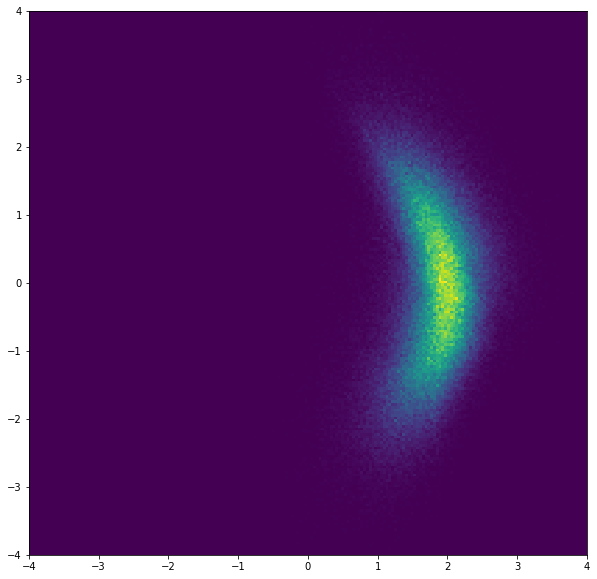

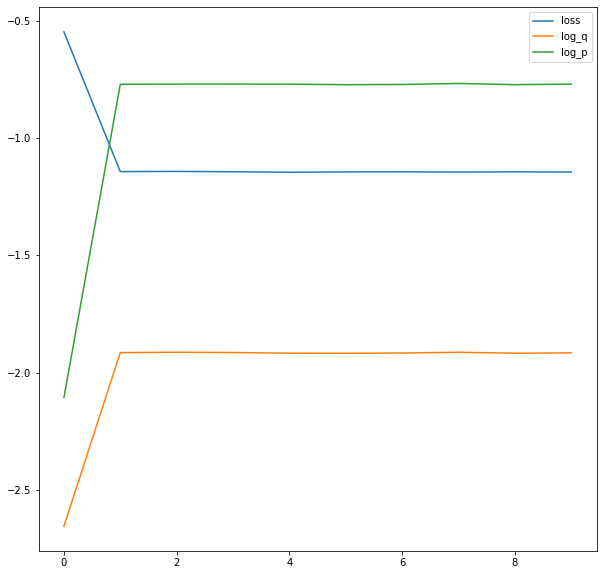


 37%|███▋      | 3708/10000 [00:14<00:24, 254.30it/s]


 74%|███████▍  | 7429/10000 [00:29<00:10, 255.37it/s]


100%|██████████| 10000/10000 [00:39<00:00, 253.45it/s][A


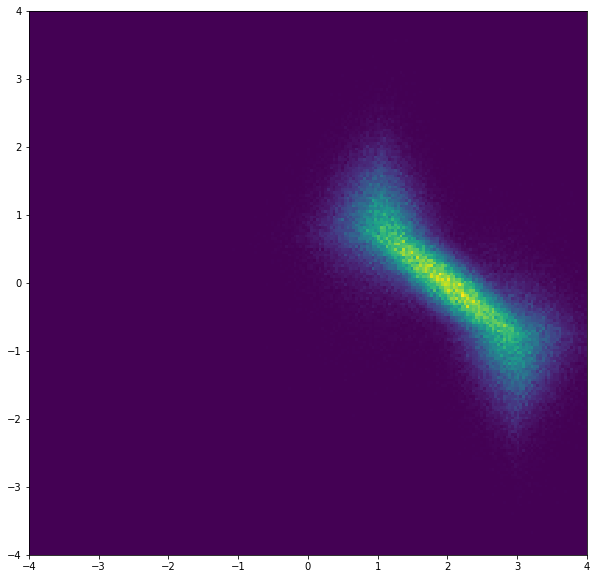

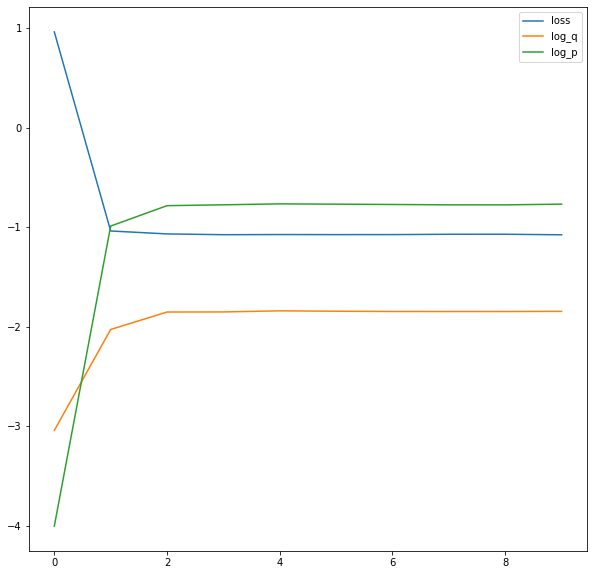


 32%|███▏      | 3228/10000 [00:14<00:30, 222.38it/s]


 65%|██████▍   | 6469/10000 [00:29<00:17, 202.85it/s]


 96%|█████████▋| 9633/10000 [00:44<00:01, 223.50it/s]


100%|██████████| 10000/10000 [00:45<00:00, 217.88it/s][A


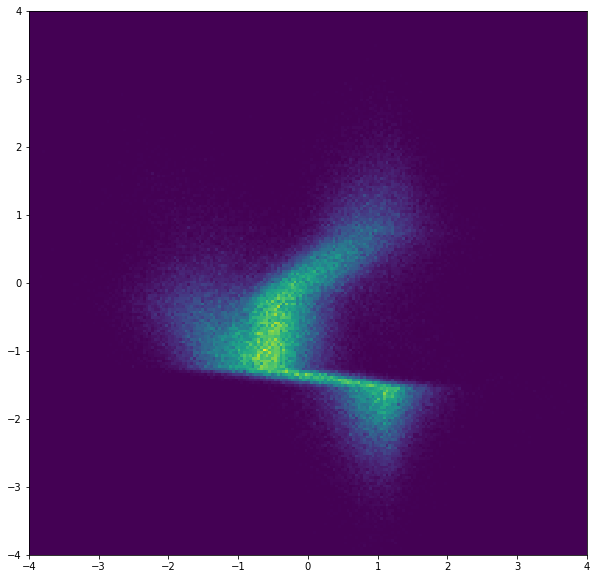

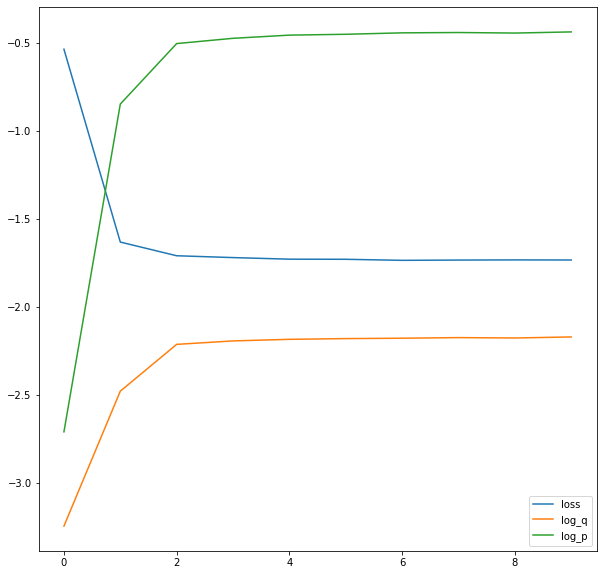


 33%|███▎      | 3271/10000 [00:14<00:38, 174.42it/s]


 65%|██████▌   | 6518/10000 [00:29<00:16, 214.79it/s]


 98%|█████████▊| 9788/10000 [00:44<00:01, 209.51it/s]


100%|██████████| 10000/10000 [00:45<00:00, 221.10it/s][A


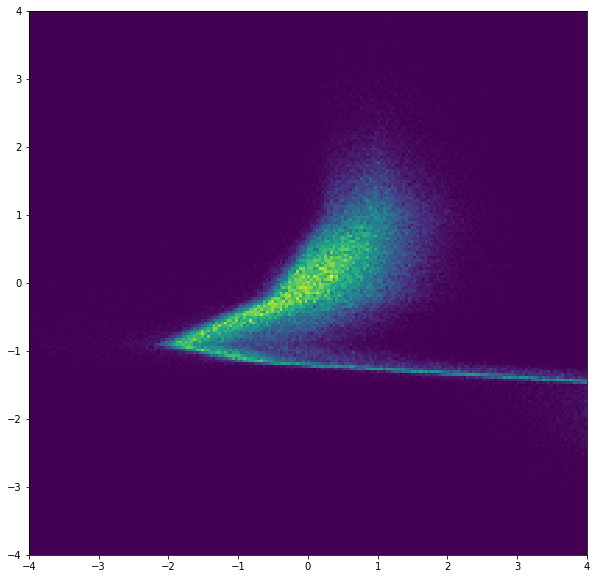

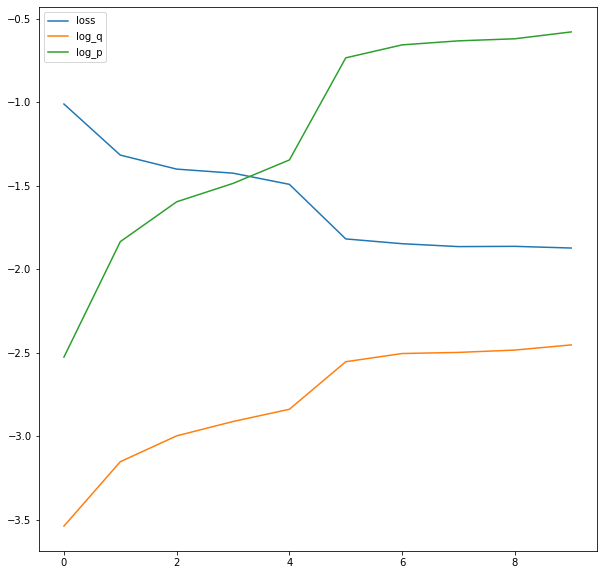


 36%|███▌      | 3552/10000 [00:14<00:26, 241.24it/s]


 71%|███████   | 7122/10000 [00:29<00:11, 243.92it/s]


100%|██████████| 10000/10000 [00:41<00:00, 241.29it/s][A


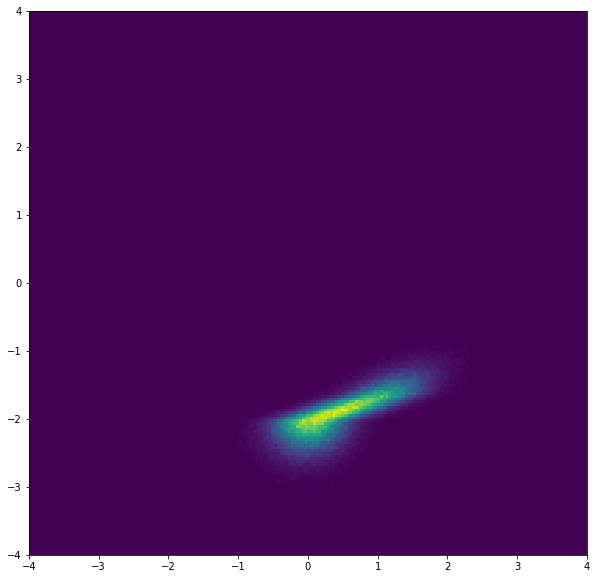

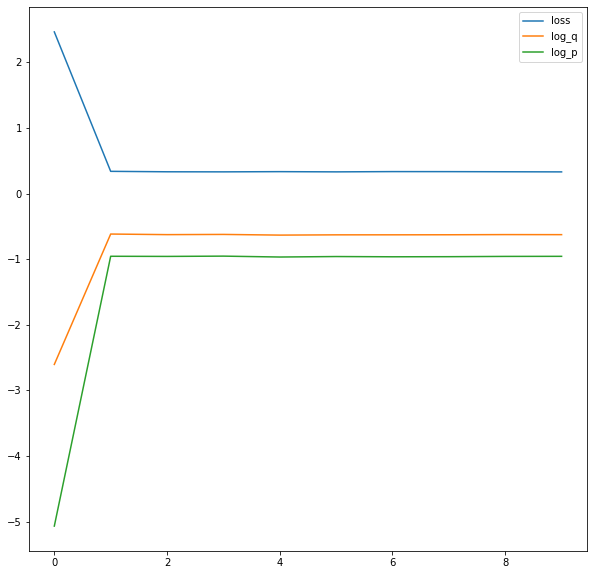


  0%|          | 9/10000 [00:00<02:02, 81.76it/s]

K = 8



 13%|█▎        | 1341/10000 [00:16<01:45, 82.46it/s]


 27%|██▋       | 2655/10000 [00:32<01:29, 81.74it/s]


 40%|███▉      | 3969/10000 [00:48<01:13, 82.05it/s]


 53%|█████▎    | 5283/10000 [01:04<00:57, 82.56it/s]


 66%|██████▌   | 6597/10000 [01:20<00:41, 82.45it/s]


 79%|███████▉  | 7911/10000 [01:36<00:25, 82.09it/s]


 92%|█████████▏| 9208/10000 [01:51<00:09, 82.27it/s]


100%|██████████| 10000/10000 [02:01<00:00, 82.23it/s][A


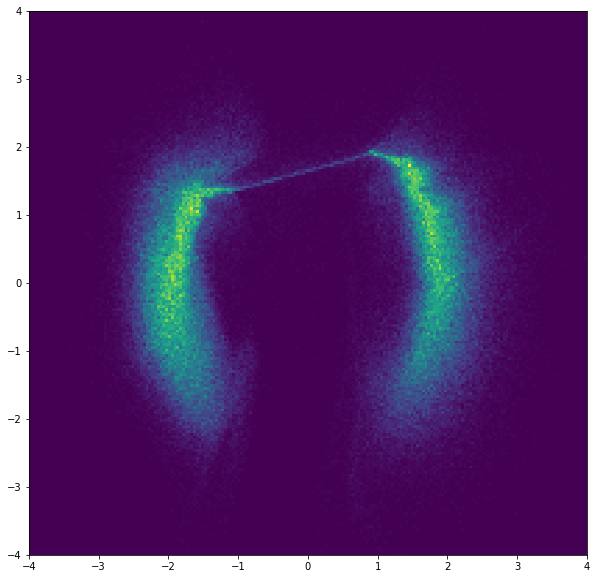

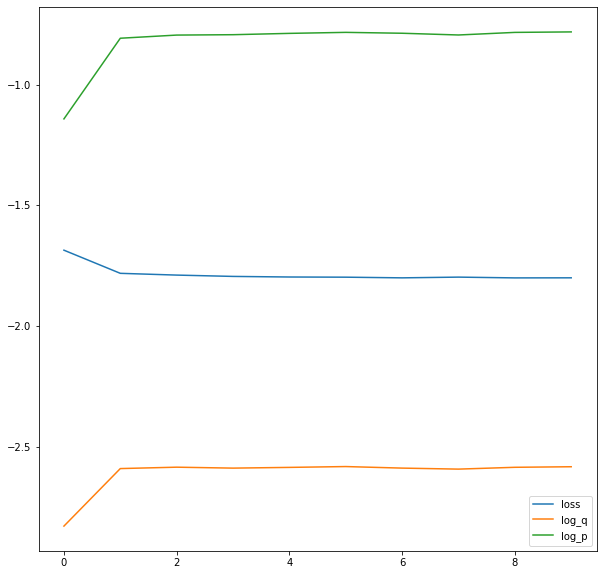


 13%|█▎        | 1320/10000 [00:15<01:42, 84.46it/s]


 26%|██▋       | 2634/10000 [00:31<01:27, 84.44it/s]


 39%|███▉      | 3948/10000 [00:46<01:10, 85.84it/s]


 53%|█████▎    | 5262/10000 [01:02<00:55, 85.10it/s]


 66%|██████▌   | 6576/10000 [01:17<00:40, 84.77it/s]


 79%|███████▉  | 7890/10000 [01:33<00:25, 84.01it/s]


 92%|█████████▏| 9204/10000 [01:48<00:09, 84.95it/s]


100%|██████████| 10000/10000 [01:57<00:00, 84.83it/s][A


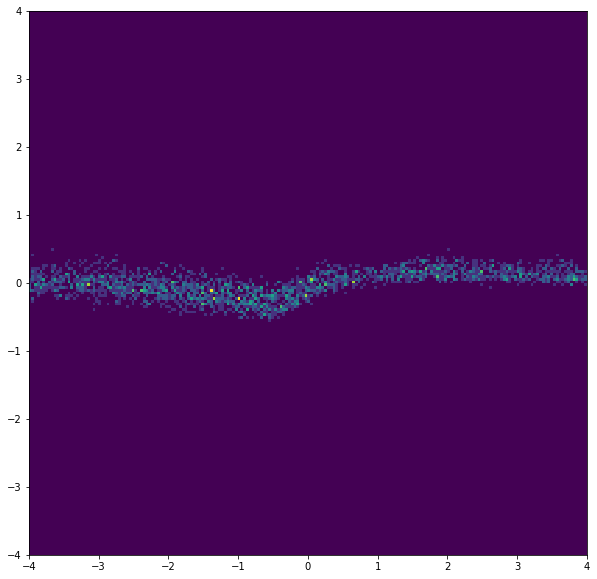

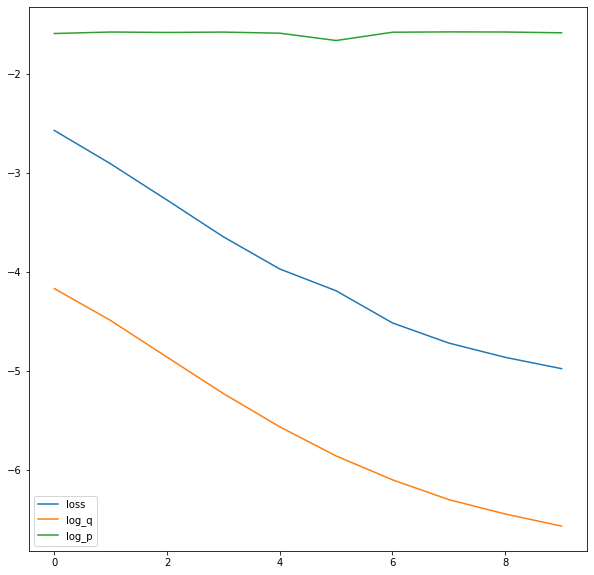


 13%|█▎        | 1318/10000 [00:16<01:45, 82.00it/s]


 26%|██▋       | 2627/10000 [00:32<01:31, 80.81it/s]


 39%|███▉      | 3933/10000 [00:48<01:13, 82.32it/s]


 52%|█████▏    | 5242/10000 [01:04<00:58, 81.30it/s]


 65%|██████▌   | 6541/10000 [01:20<00:42, 81.31it/s]


 78%|███████▊  | 7844/10000 [01:36<00:26, 80.84it/s]


 92%|█████████▏| 9155/10000 [01:52<00:10, 81.22it/s]


100%|██████████| 10000/10000 [02:03<00:00, 81.01it/s]


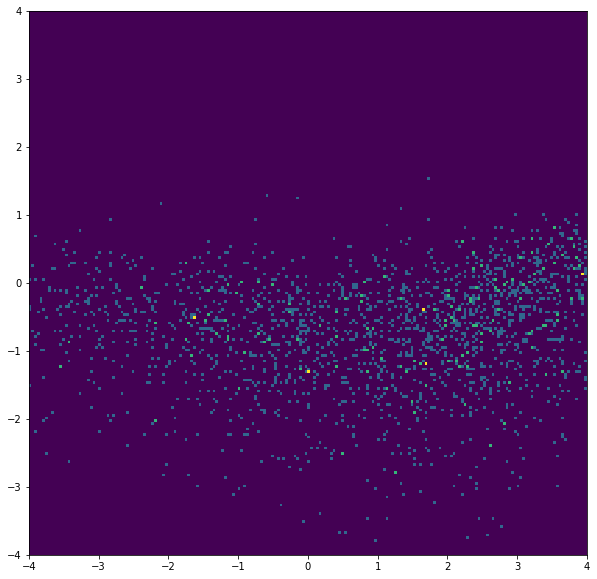

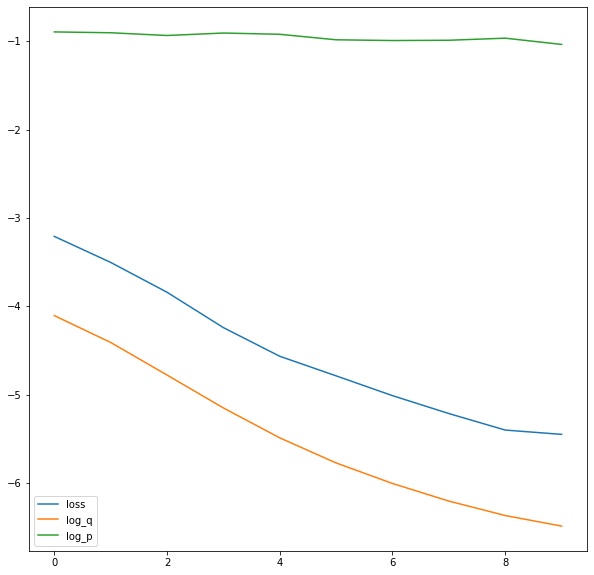


 13%|█▎        | 1319/10000 [00:16<01:47, 80.72it/s]


 26%|██▋       | 2629/10000 [00:32<01:31, 80.48it/s]


 39%|███▉      | 3943/10000 [00:48<01:14, 81.35it/s]


 53%|█████▎    | 5257/10000 [01:04<00:57, 82.53it/s]


 66%|██████▌   | 6571/10000 [01:20<00:42, 81.42it/s]


 79%|███████▉  | 7885/10000 [01:36<00:26, 79.91it/s]


 92%|█████████▏| 9199/10000 [01:52<00:09, 81.78it/s]


100%|██████████| 10000/10000 [02:02<00:00, 81.57it/s]


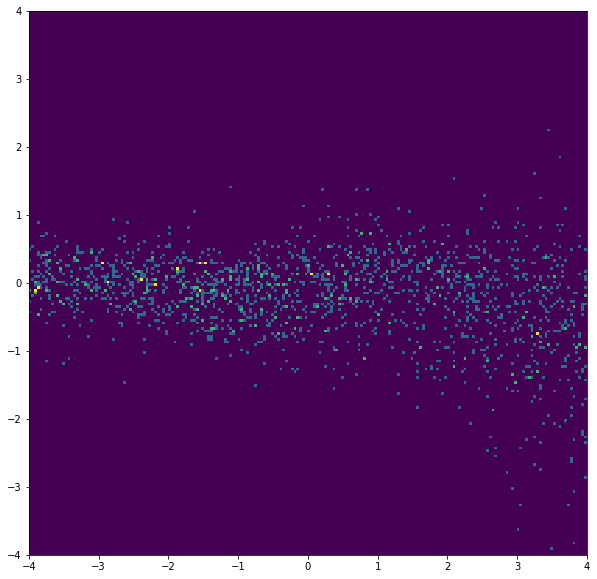

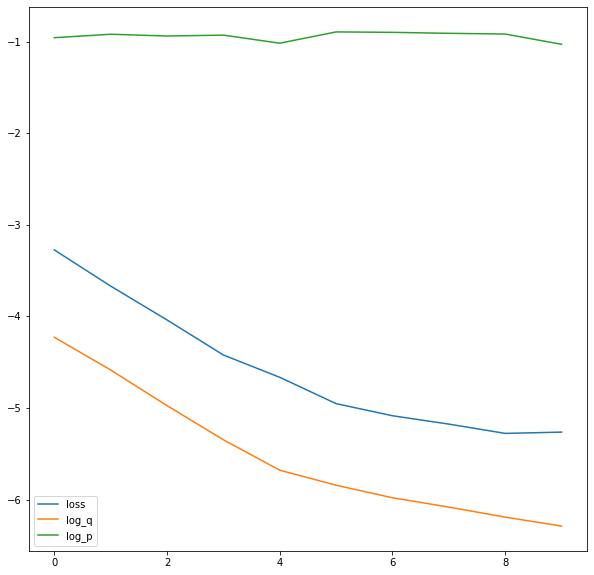


 13%|█▎        | 1323/10000 [00:15<01:42, 84.48it/s]


 26%|██▋       | 2637/10000 [00:31<01:28, 83.15it/s]


 40%|███▉      | 3951/10000 [00:47<01:13, 82.70it/s]


 53%|█████▎    | 5265/10000 [01:03<00:57, 82.85it/s]


 66%|██████▌   | 6579/10000 [01:18<00:40, 84.23it/s]


 79%|███████▉  | 7893/10000 [01:34<00:25, 83.68it/s]


 92%|█████████▏| 9207/10000 [01:50<00:09, 83.79it/s]


100%|██████████| 10000/10000 [01:59<00:00, 83.48it/s][A


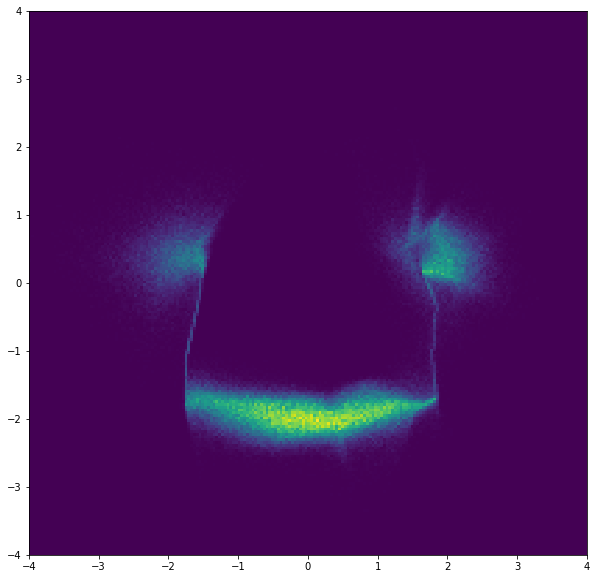

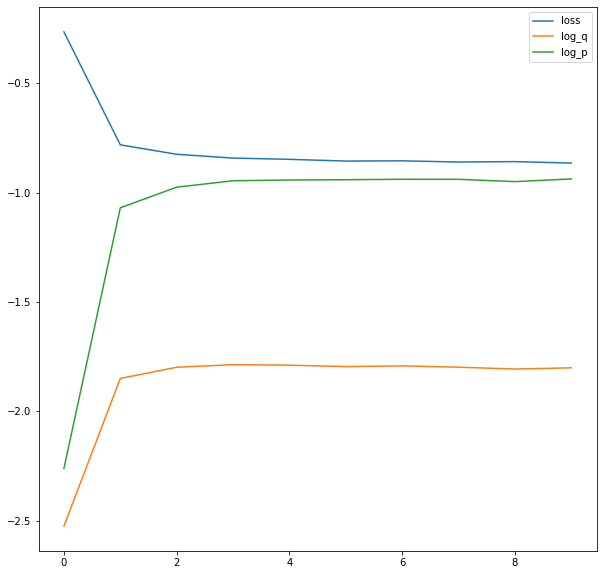


  0%|          | 3/10000 [00:00<07:25, 22.46it/s]

K = 32



  4%|▍         | 450/10000 [00:19<06:59, 22.75it/s]


  9%|▉         | 894/10000 [00:39<06:37, 22.91it/s]


 13%|█▎        | 1332/10000 [00:58<06:15, 23.09it/s]


 18%|█▊        | 1770/10000 [01:17<05:57, 23.05it/s]


 22%|██▏       | 2208/10000 [01:36<05:49, 22.28it/s]


 26%|██▋       | 2646/10000 [01:55<05:22, 22.81it/s]


 31%|███       | 3084/10000 [02:14<04:59, 23.07it/s]


 35%|███▌      | 3522/10000 [02:33<04:44, 22.74it/s]


 40%|███▉      | 3960/10000 [02:52<04:21, 23.09it/s]


 44%|████▍     | 4398/10000 [03:11<04:01, 23.21it/s]


 48%|████▊     | 4836/10000 [03:30<03:45, 22.94it/s]


 53%|█████▎    | 5274/10000 [03:50<03:26, 22.92it/s]


 57%|█████▋    | 5712/10000 [04:09<03:05, 23.07it/s]


 62%|██████▏   | 6150/10000 [04:28<02:48, 22.82it/s]


 66%|██████▌   | 6588/10000 [04:47<02:29, 22.78it/s]


 70%|███████   | 7026/10000 [05:06<02:07, 23.27it/s]


 75%|███████▍  | 7464/10000 [05:25<01:51, 22.80it/s]


 79%|███████▉  | 7902/10000 [05:44<01:31, 22.88it/s]


 83%|████████▎ | 8340/10000 [06:03<01:12, 22.86it/s]


 88%|████████▊ | 8778/10000 [06:23<00:53, 22.70it/s]


 92%|█████████▏| 9216/10000 [06:42<00:34, 22.95it/s]


 97%|█████████▋| 9654/10000 [07:01<00:15, 22.89it/s]


100%|██████████| 10000/10000 [07:16<00:00, 22.92it/s][A


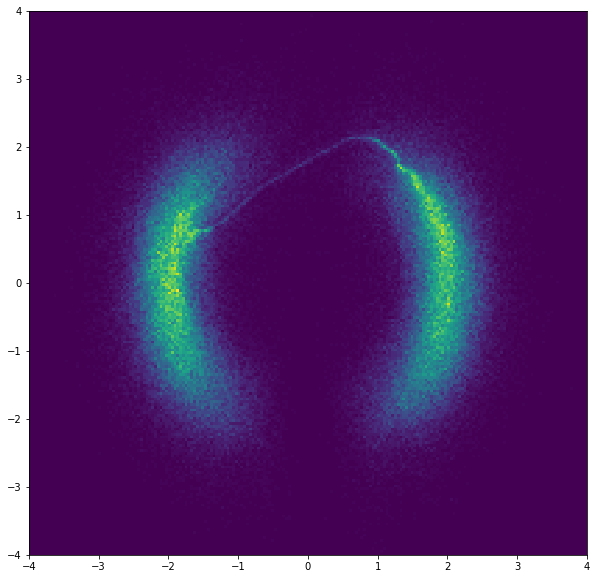

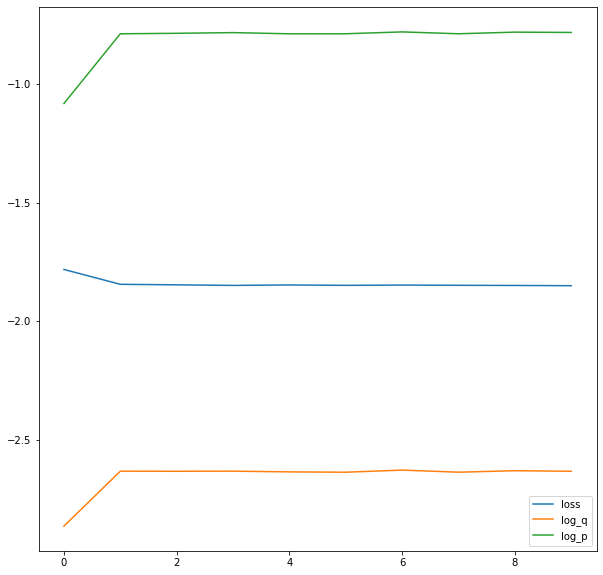


  4%|▍         | 444/10000 [00:19<06:53, 23.09it/s]


  9%|▉         | 888/10000 [00:38<06:30, 23.34it/s]


 13%|█▎        | 1326/10000 [00:57<06:09, 23.47it/s]


 18%|█▊        | 1764/10000 [01:16<05:54, 23.22it/s]


 22%|██▏       | 2202/10000 [01:34<05:33, 23.35it/s]


 26%|██▋       | 2640/10000 [01:53<05:14, 23.42it/s]


 31%|███       | 3078/10000 [02:12<04:56, 23.33it/s]


 35%|███▌      | 3516/10000 [02:31<04:38, 23.24it/s]


 40%|███▉      | 3954/10000 [02:50<04:22, 23.07it/s]


 44%|████▍     | 4392/10000 [03:09<04:03, 23.07it/s]


 48%|████▊     | 4830/10000 [03:28<03:49, 22.57it/s]


 53%|█████▎    | 5268/10000 [03:47<03:21, 23.48it/s]


 57%|█████▋    | 5706/10000 [04:06<03:05, 23.14it/s]


 61%|██████▏   | 6144/10000 [04:25<02:47, 23.09it/s]


 66%|██████▌   | 6582/10000 [04:44<02:25, 23.54it/s]


 70%|███████   | 7020/10000 [05:03<02:09, 23.07it/s]


 75%|███████▍  | 7458/10000 [05:22<01:49, 23.12it/s]


 79%|███████▉  | 7896/10000 [05:41<01:30, 23.34it/s]


 83%|████████▎ | 8334/10000 [06:00<01:11, 23.17it/s]


 88%|████████▊ | 8772/10000 [06:19<00:52, 23.20it/s]


 92%|█████████▏| 9210/10000 [06:38<00:34, 22.82it/s]


 96%|█████████▋| 9648/10000 [06:57<00:15, 23.21it/s]


100%|██████████| 10000/10000 [07:12<00:00, 23.13it/s][A


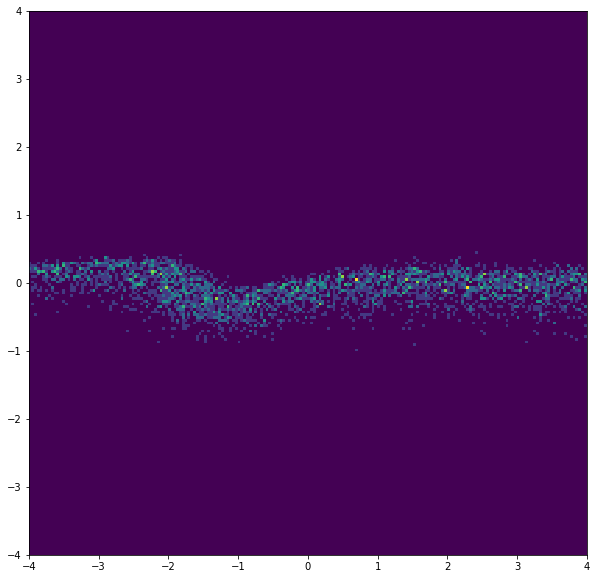

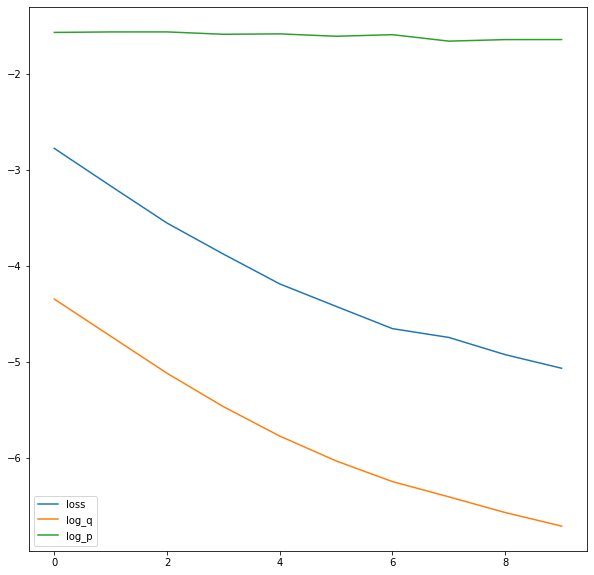


  4%|▍         | 444/10000 [00:19<07:02, 22.64it/s]


  9%|▉         | 888/10000 [00:39<06:43, 22.60it/s]


 13%|█▎        | 1326/10000 [00:58<06:17, 22.99it/s]


 18%|█▊        | 1764/10000 [01:17<06:05, 22.52it/s]


 22%|██▏       | 2202/10000 [01:36<05:42, 22.76it/s]


 26%|██▋       | 2640/10000 [01:55<05:20, 23.00it/s]


 31%|███       | 3078/10000 [02:15<05:05, 22.66it/s]


 35%|███▌      | 3516/10000 [02:34<04:44, 22.75it/s]


 40%|███▉      | 3954/10000 [02:53<04:23, 22.90it/s]


 44%|████▍     | 4392/10000 [03:12<04:04, 22.91it/s]


 48%|████▊     | 4830/10000 [03:32<03:45, 22.97it/s]


 53%|█████▎    | 5268/10000 [03:51<03:24, 23.13it/s]


 57%|█████▋    | 5706/10000 [04:10<03:07, 22.93it/s]


 61%|██████▏   | 6144/10000 [04:29<02:51, 22.50it/s]


 66%|██████▌   | 6582/10000 [04:48<02:27, 23.14it/s]


 70%|███████   | 7020/10000 [05:07<02:11, 22.71it/s]


 75%|███████▍  | 7458/10000 [05:27<01:50, 23.07it/s]


 79%|███████▉  | 7896/10000 [05:46<01:32, 22.70it/s]


 83%|████████▎ | 8334/10000 [06:05<01:12, 22.91it/s]


 88%|████████▊ | 8772/10000 [06:24<00:53, 22.95it/s]


 92%|█████████▏| 9210/10000 [06:44<00:34, 22.90it/s]


 96%|█████████▋| 9648/10000 [07:03<00:15, 22.57it/s]


100%|██████████| 10000/10000 [07:19<00:00, 22.78it/s][A


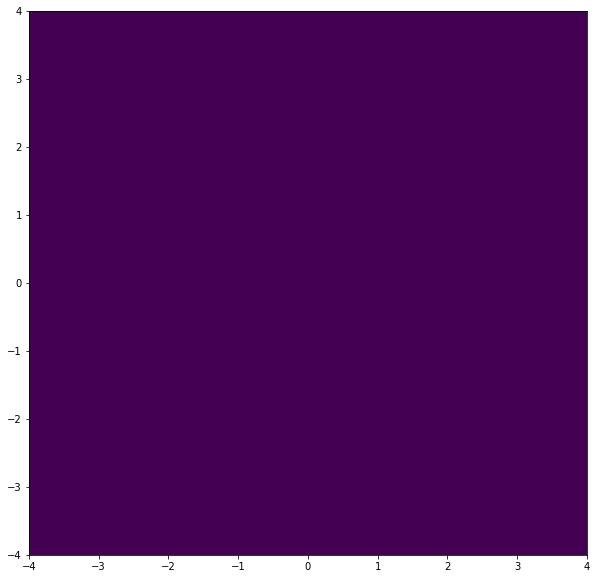

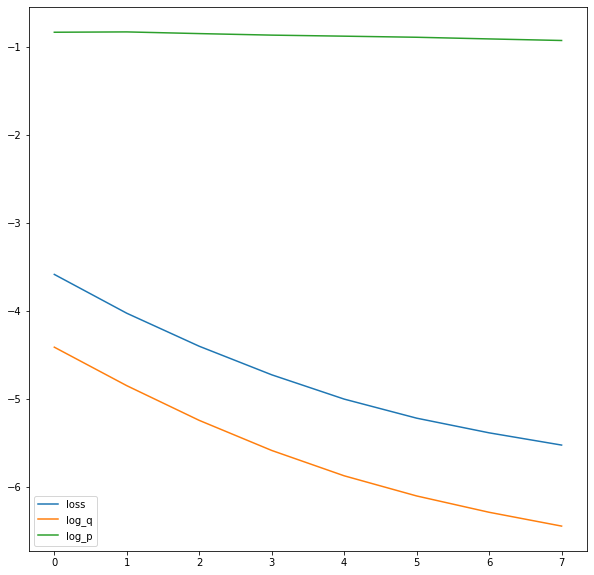


  4%|▍         | 444/10000 [00:19<06:57, 22.90it/s]


  9%|▉         | 888/10000 [00:38<06:40, 22.73it/s]


 13%|█▎        | 1326/10000 [00:58<06:26, 22.46it/s]


 18%|█▊        | 1764/10000 [01:17<05:59, 22.90it/s]


 20%|██        | 2031/10000 [01:28<05:53, 22.57it/s]

KeyboardInterrupt: 

In [12]:
# NICE
max_iter = 20000
K_arr = [2, 8, 32]
for K in K_arr:
    
    print("K = {}".format(K))
    for k in range(0,5):
        if k == 0 or k == 4:
            anneal_iter = 10000
        else:
            anneal_iter = 1
        
        flows = []
        for i in range(K):
            flows += [nf.flows.AffineHalfFlow((2,), parity=i%2, scale=False)]

        q0 = nf.distributions.ConstDiagGaussian(np.zeros(2), 2.0)
        nfm = nf.NormalizingFlow(prior=priors[k], q0=q0, flows=flows)
        nfm.to(dev) # Move model on GPU if available
    
        # Train model
        loss_hist = np.array([])
        log_q_hist = np.array([])
        log_p_hist = np.array([])
        x = torch.zeros(batch_size, device=dev)

        optimizer = torch.optim.Adam(nfm.parameters(), lr=1e-3, weight_decay=1e-3)
        for it in tqdm(range(max_iter)):
            optimizer.zero_grad()
            _, log_q, log_p = nfm(x, num_samples)
            mean_log_q = torch.mean(log_q)
            mean_log_p = torch.mean(log_p)
            loss = mean_log_q - np.min([1.0, 0.01 + it / anneal_iter]) * mean_log_p
            loss.backward()
            optimizer.step()
            
            if (it + 1) % save_iter == 0:
                loss_hist = np.append(loss_hist, loss.cpu().data.numpy())
                log_q_hist = np.append(log_q_hist, mean_log_q.cpu().data.numpy())
                log_p_hist = np.append(log_p_hist, mean_log_p.cpu().data.numpy())

        # Plot learned posterior distribution
        z, _, _ = nfm(torch.zeros(512).to(dev), num_samples=512)
        z_np = z.cpu().data.numpy()
        plt.figure(figsize=(10, 10))
        plt.hist2d(z_np[:, :, 0].flatten(), z_np[:, :, 1].flatten(), (grid_size, grid_size), grid_shape)
        plt.show()
        np.save("nice_K={}-k={}".format(K,k), (z_np, loss.cpu().data.numpy()))
    
        # Plot training history
        plt.figure(figsize=(10, 10))
        plt.plot(loss_hist, label='loss')
        plt.plot(log_q_hist, label='log_q')
        plt.plot(log_p_hist, label='log_p')
        plt.legend()
        plt.show() 

FileNotFoundError: [Errno 2] No such file or directory: 'nice_K=32-k=3.npy'

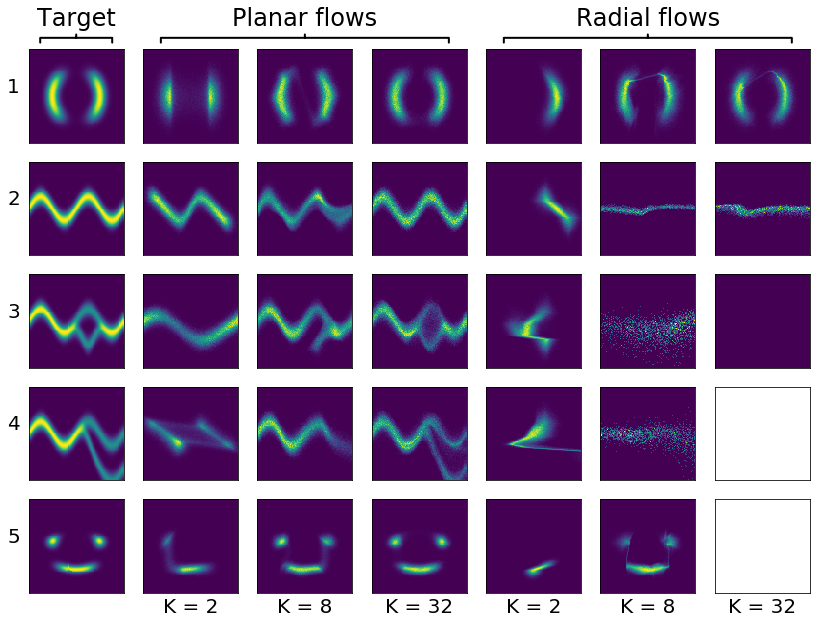

In [11]:
# expressivity plot of the Planar and Radial flows
fig = plt.figure(figsize=(14, 10))
K_arr = [2, 8, 32]
nrows=5
ncols=7
axes = [ fig.add_subplot(nrows, ncols, r * ncols + c + 1) for r in range(0, nrows) for c in range(0, ncols) ]

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

grid_size = 100
grid_length = 4.0
grid_shape = ([-grid_length, grid_length], [-grid_length, grid_length])

space_mesh = torch.linspace(-grid_length, grid_length, grid_size)
xx, yy = torch.meshgrid(space_mesh, space_mesh)
z = torch.cat([xx.unsqueeze(2), yy.unsqueeze(2)], 2)
axes[0].annotate('Target', xy=(0.5, 1.10), xytext=(0.5, 1.20), xycoords='axes fraction', 
            fontsize=24, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.5, lengthB=0.2', lw=2.0))
for k in range(5):
    axes[k*ncols].set_ylabel('{}'.format(k+1), rotation=0, fontsize=20, labelpad=15)
    log_prob = priors[k].log_prob(z)
    prob = torch.exp(log_prob)
    axes[k*ncols + 0].pcolormesh(xx, yy, prob)


for l in range(len(K_arr)):
    K = K_arr[l]
    if l == 1:
        axes[0*ncols + l+1].annotate('Planar flows', xy=(0.5, 1.10), xytext=(0.5, 1.20), xycoords='axes fraction', 
            fontsize=24, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=6.0, lengthB=0.2', lw=2.0))
    axes[4*ncols + l+1].set_xlabel('K = {}'.format(K), fontsize=20)
    for k in range(5):
        z_np, _ = np.load("K={}-k={}.npy".format(K,k), allow_pickle=True)
        axes[k*ncols + l+1].hist2d(z_np[:, :, 0].flatten(), z_np[:, :, 1].flatten(), (grid_size, grid_size), grid_shape)
        
for l in range(len(K_arr)):
    K = K_arr[l]
    if l == 1:
        axes[0*ncols + l+1+len(K_arr)].annotate('Radial flows', xy=(0.5, 1.10), xytext=(0.5, 1.20), xycoords='axes fraction', 
            fontsize=24, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=6.0, lengthB=0.2', lw=2.0))
    axes[4*ncols + l+1+len(K_arr)].set_xlabel('K = {}'.format(K), fontsize=20)
    for k in range(5):
        z_np, _ = np.load("rad_K={}-k={}.npy".format(K,k), allow_pickle=True)
        axes[k*ncols + l+1+len(K_arr)].hist2d(z_np[:, :, 0].flatten(), z_np[:, :, 1].flatten(), (grid_size, grid_size), grid_shape)

fig.subplots_adjust(hspace=0.02, wspace=0.02)

for l in range(1,4):
    for k in range(5):
        pos1 = axes[k*ncols + l].get_position() # get the original position 
        pos2 = [pos1.x0 + 0.01, pos1.y0,  pos1.width, pos1.height] 
        axes[k*ncols + l].set_position(pos2) # set a new position
        
for l in range(4,7):
    for k in range(5):
        pos1 = axes[k*ncols + l].get_position() # get the original position 
        pos2 = [pos1.x0 + 0.02, pos1.y0,  pos1.width, pos1.height] 
        axes[k*ncols + l].set_position(pos2) # set a new position


In [45]:
# Glow
max_iter = 1000
K_arr = [2, 8, 32]
for K in K_arr:
    
    print("K = {}".format(K))
    for k in range(0,5):
        if k == 0 or k == 4:
            anneal_iter = 10000
        else:
            anneal_iter = 1
        
        flows = []
        for i in range(K):
            flows += [nf.flows.Glow((2,), i%2)]

        q0 = nf.distributions.ConstDiagGaussian(np.zeros(2), 2.0)
        nfm = nf.NormalizingFlow(prior=priors[k], q0=q0, flows=flows)
        nfm.to(dev) # Move model on GPU if available
    
        # Train model
        loss_hist = np.array([])
        log_q_hist = np.array([])
        log_p_hist = np.array([])
        x = torch.zeros(batch_size, device=dev)

        optimizer = torch.optim.Adam(nfm.parameters(), lr=1e-3, weight_decay=1e-3)
        for it in tqdm(range(max_iter)):
            optimizer.zero_grad()
            _, log_q, log_p = nfm(x, num_samples)
            mean_log_q = torch.mean(log_q)
            mean_log_p = torch.mean(log_p)
            loss = mean_log_q - np.min([1.0, 0.01 + it / anneal_iter]) * mean_log_p
            loss.backward()
            optimizer.step()
            
            if (it + 1) % save_iter == 0:
                loss_hist = np.append(loss_hist, loss.cpu().data.numpy())
                log_q_hist = np.append(log_q_hist, mean_log_q.cpu().data.numpy())
                log_p_hist = np.append(log_p_hist, mean_log_p.cpu().data.numpy())

        # Plot learned posterior distribution
        z, _, _ = nfm(torch.zeros(512).to(dev), num_samples=512)
        z_np = z.cpu().data.numpy()
        plt.figure(figsize=(10, 10))
        plt.hist2d(z_np[:, :, 0].flatten(), z_np[:, :, 1].flatten(), (grid_size, grid_size), grid_shape)
        plt.show()
        np.save("glow_K={}-k={}".format(K,k), (z_np, loss.cpu().data.numpy()))
    
        # Plot training history
        plt.figure(figsize=(10, 10))
        plt.plot(loss_hist, label='loss')
        plt.plot(log_q_hist, label='log_q')
        plt.plot(log_p_hist, label='log_p')
        plt.legend()
        plt.show() 

  0%|          | 0/1000 [00:00<?, ?it/s]

K = 2


RuntimeError: Expected object of scalar type Double but got scalar type Float for argument #2 'mat2' in call to _th_mm

In [ ]:
# comparison of Planar, Radial, GLOW, CNF on given prior distribution

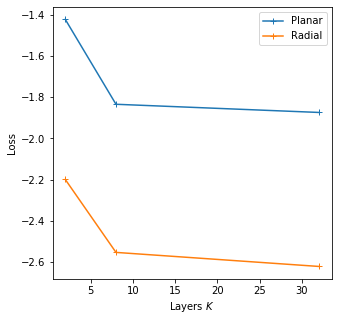

In [14]:
loss_plan = []
loss_rad = []
k = 0 # pick the TwoModes distribution
6
for K in K_arr:
    _, loss = np.load("K={}-k={}.npy".format(K,k), allow_pickle=True)
    loss_plan.append(loss)
    _, loss = np.load("rad_K={}-k={}.npy".format(K,k), allow_pickle=True,)
    loss_rad.append(loss)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
#fig.tight_layout(pad=3.0)
axes.plot(K_arr, loss_plan, marker='+', label='Planar')
axes.plot(K_arr, loss_rad, marker='+', label='Radial')
axes.set_xlabel('Layers $K$')
axes.set_ylabel('Loss')
axes.legend()